<a href="https://colab.research.google.com/github/nikitaoltyan/ML-Homework/blob/main/Assignment6/Unet_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Setup

In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

In [2]:
# Run this cell if you are in Colab
# Else download data https://drive.google.com/file/d/1AdrduuNb83hvi4cQ-1v-ojhjWL1OUAZr/view?usp=sharing
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1AdrduuNb83hvi4cQ-1v-ojhjWL1OUAZr"})   
downloaded.GetContentFile('cityscapes.zip')

In [4]:
! unzip cityscapes.zip

Archive:  cityscapes.zip
replace cityscapes_data/val/213.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [6]:
data_dir = "cityscapes_data"
train_dir = os.path.join(data_dir, "train") 
val_dir = os.path.join(data_dir, "val")
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)
print(len(train_fns), len(val_fns))

2975 500


## 2. Analyze data

cityscapes_data/train/250.jpg


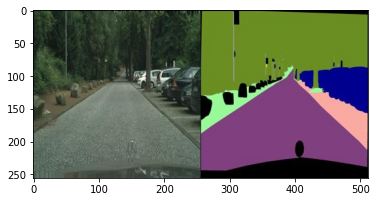

In [7]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

In [8]:
def split_image(image):
    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label

(256, 512, 3)
0 255 0 255


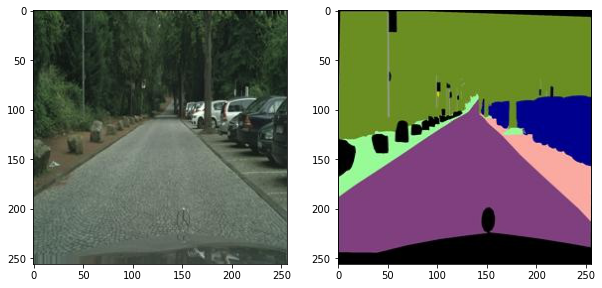

In [9]:
sample_image = np.array(sample_image)
print(sample_image.shape)
cityscape, label = split_image(sample_image)
print(cityscape.min(), cityscape.max(), label.min(), label.max())
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

## 3. Define Labels

In [10]:
"""
color_set = set()
for train_fn in tqdm(train_fns[:10]):
    train_fp = os.path.join(train_dir, train_fn)
    image = np.array(Image.open(train_fp))
    cityscape, label = split_image(sample_image)
    label = label.reshape(-1, 3)
    local_color_set = set([tuple(c) for c in list(label)])
    color_set.update(local_color_set)
color_array = np.array(list(color_set))
"""

num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(color_array.shape)
print(color_array[:5, :])

(1000, 3)
[[ 55 186 178]
 [108 179  38]
 [ 62 225 246]
 [210  60 206]
 [162 137  74]]


In [11]:
num_classes = 10
label_model = KMeans(n_clusters=num_classes)
label_model.fit(color_array)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [12]:
label_model.predict(color_array[:5, :])

array([7, 2, 7, 9, 6], dtype=int32)

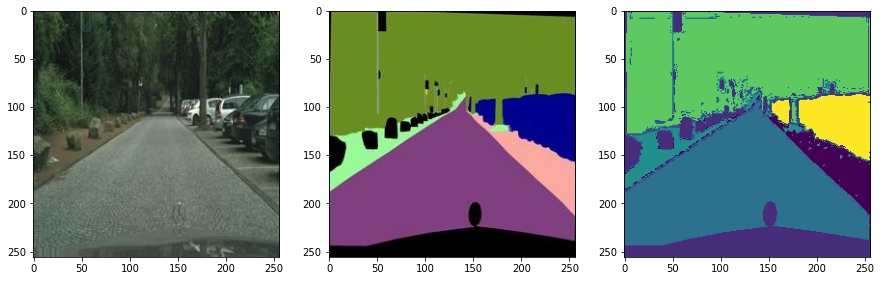

In [13]:
cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

In [14]:
label_class

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)

Вопрос: Зачем нужен алгоритм KMeans?  
Ответ: 

## 4. Define Dataset

In [15]:
class CityscapeDataset(Dataset):
    
    def __init__(self, image_dir, label_model):
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        self.label_model = label_model
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.image_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = np.array(image)
        cityscape, label = self.split_image(image)
        label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
        cityscape = self.transform(cityscape)
        label_class = torch.Tensor(label_class).long()
        return cityscape, label_class
    
    def split_image(self, image):
        image = np.array(image)
        cityscape, label = image[:, :256, :], image[:, 256:, :]
        return cityscape, label
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [16]:
dataset = CityscapeDataset(train_dir, label_model)
print(len(dataset))

2975


In [17]:
cityscape, label_class = dataset[0]
print(cityscape.shape, label_class.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256])


## 5. Define Model

In [97]:
def conv(in_channel, out_channel):
    conv = nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1),
        nn.ReLU()
    )
    return conv


def crop_tensor(target_tensor, tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta // 2
    return tensor[:, :, delta:tensor_size- delta, delta:tensor_size-delta]

In [102]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        # TODO: Implement Unet layers
        # Going down
        self.down1 = conv(3, 32)
        self.down2 = conv(32, 64)
        self.down3 = conv(64, 128)
        self.down4 = conv(128, 256)
        self.down5 = conv(256, 512)

        self.maxpool = nn.MaxPool2d(kernel_size=2)

        # Going up
        self.trans1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up1 = conv(512, 256)
        self.trans2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up2 = conv(256, 128)
        self.trans3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up3 = conv(128, 64)
        self.trans4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.up4 = conv(64, 32)

        self.out = nn.Conv2d(32, num_classes, kernel_size=1)

        
   
    def forward(self, X):
        # TODO: Implement Unet forward pass
        fw_1_down = self.down1(X)
        fw_1_down_maxpool = self.maxpool(fw_1_down)

        fw_2_down = self.down2(fw_1_down_maxpool)
        fw_2_down_maxpool = self.maxpool(fw_2_down)

        fw_3_down = self.down3(fw_2_down_maxpool)
        fw_3_down_maxpool = self.maxpool(fw_3_down)

        fw_4_down = self.down4(fw_3_down_maxpool)
        fw_4_down_maxpool = self.maxpool(fw_4_down)

        fw_5_down = self.down5(fw_4_down_maxpool)


        fw_5_up = self.trans1(fw_5_down)
        conc = crop_tensor(fw_5_up, fw_4_down)
        fw_5_up_upscale = self.up1(torch.cat([fw_5_up,conc], 1))

        fw_6_up = self.trans2(fw_5_up_upscale)
        conc = crop_tensor(fw_6_up, fw_3_down)
        fw_6_up_upscale = self.up2(torch.cat([fw_6_up,conc], 1))

        fw_7_up = self.trans3(fw_6_up_upscale)
        conc = crop_tensor(fw_7_up, fw_2_down)
        fw_7_up_upscale = self.up3(torch.cat([fw_7_up,conc], 1))

        fw_8_up = self.trans4(fw_7_up_upscale)
        conc = crop_tensor(fw_8_up, fw_1_down)
        fw_8_up_upscale = self.up4(torch.cat([fw_8_up,conc], 1))
        
        output_out = self.out(fw_8_up_upscale)

        return output_out


In [103]:
model = UNet(num_classes=num_classes)

In [104]:
data_loader = DataLoader(dataset, batch_size=4)
print(len(dataset), len(data_loader))

X, Y = iter(data_loader).next()
print(X.shape, Y.shape)

2975 744
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])


In [105]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 10, 256, 256])


## 6. Train the model

In [106]:
batch_size = 16

epochs = 10
lr = 0.01

In [107]:
dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size=batch_size)

In [108]:
model = UNet(num_classes=num_classes).to(device)

In [109]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [110]:
step_losses = []
epoch_losses = []
for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    for X, Y in tqdm(data_loader, total=len(data_loader), leave=False):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
    epoch_losses.append(epoch_loss/len(data_loader))

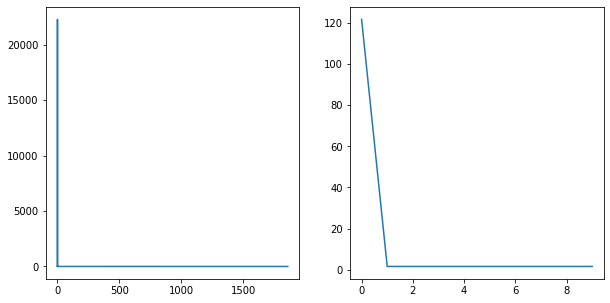

In [111]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

In [112]:
model_name = "U-Net.pth"
torch.save(model.state_dict(), model_name)

## 7. Check model predictions

In [113]:
model_path = "U-Net.pth"
model_ = UNet(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [114]:
test_batch_size = 8
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [115]:
X, Y = next(iter(data_loader))
X, Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([8, 10, 256, 256])
torch.Size([8, 256, 256])


In [116]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

Вопрос: Зачем нужен inverse_transform?  
Ответ: 

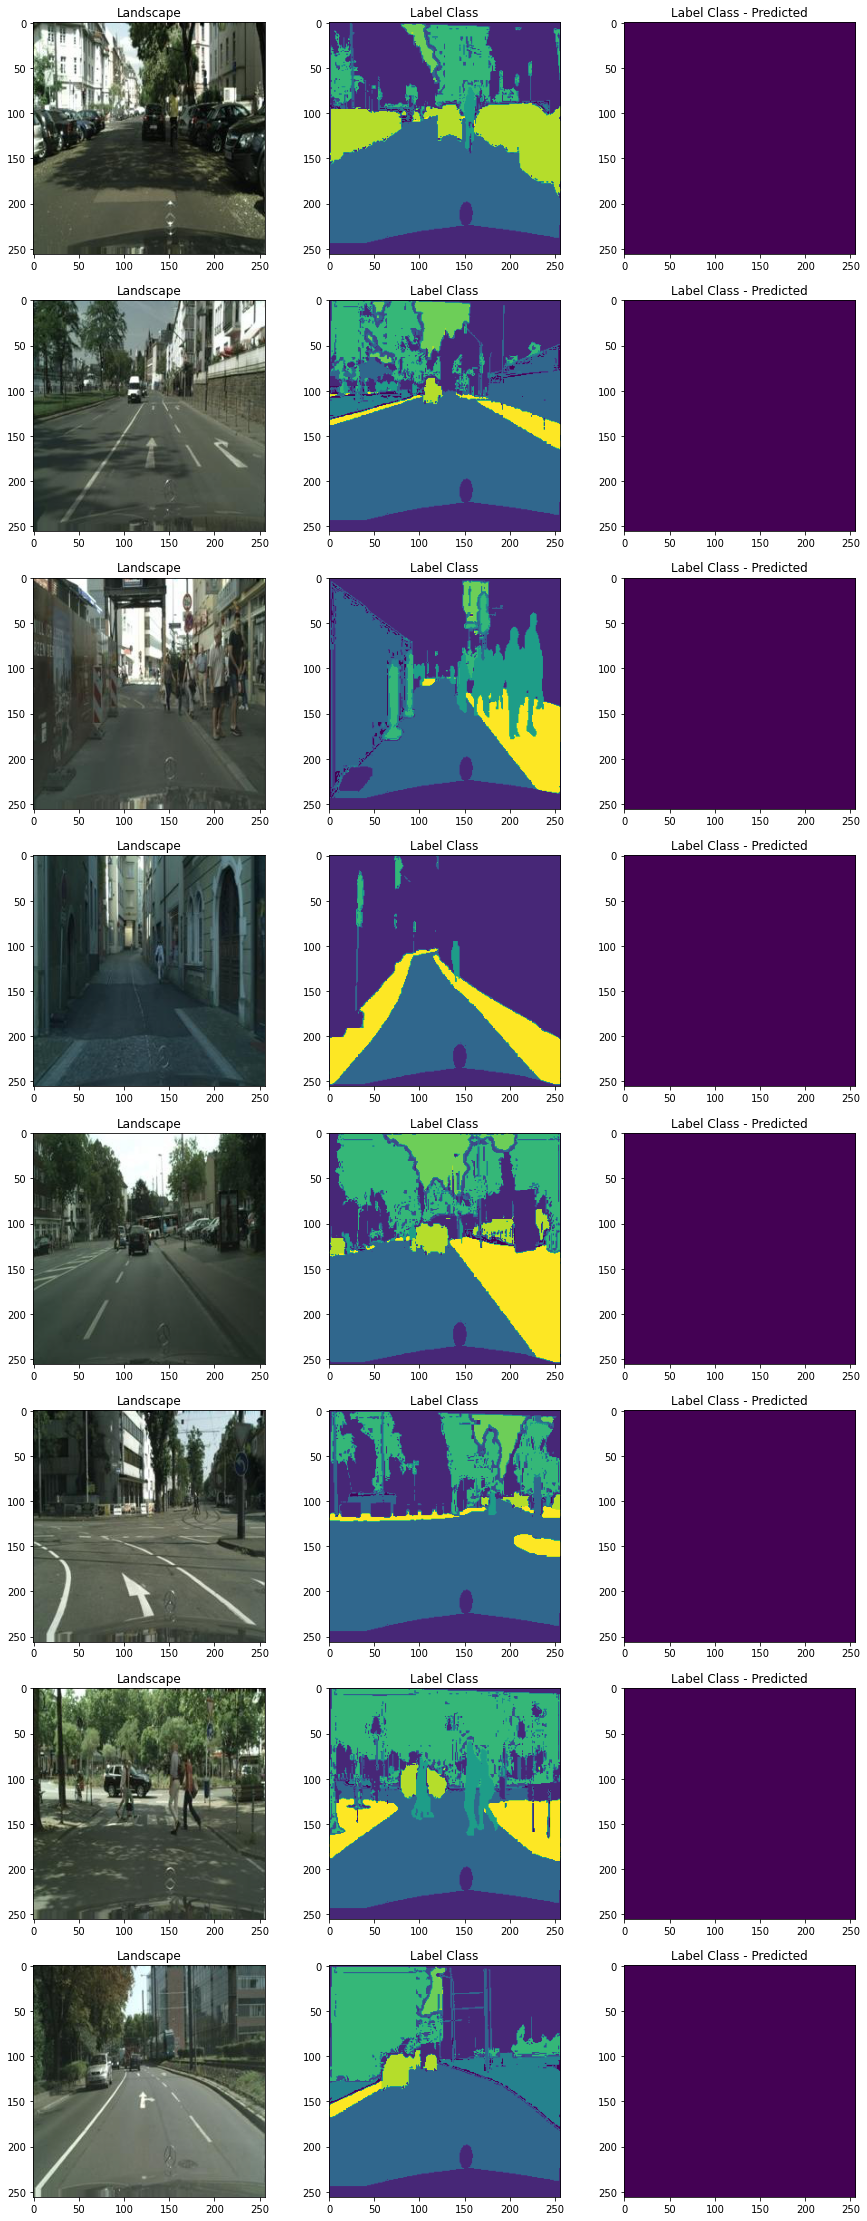

In [117]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")